# Convert Single DICOM file to Pseudo(Multiple) Color Image

In [ ]:
!pip install -q pydicom numpy matplotlib Pillow
import os
import cv2
import numpy as np
import pydicom
from PIL import Image
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.8 MB/s eta 0:00:00


In [ ]:
def window_image(dcm, window_center,window_width, rescale=True):
    '''
    This fucntion came from this notebook https://www.kaggle.com/code/redwankarimsony/ct-scans-dicom-files-windowing-explained
    If you want to understand more about windowing the referenced notebook is a good read.
    '''
    img = dcm.pixel_array
    slope = dcm.RescaleSlope
    intercept = dcm.RescaleIntercept
    img = (img*slope +intercept) #for translation adjustments given in the dicom file.
    img_min = window_center - window_width//2 #minimum HU level
    img_max = window_center + window_width//2 #maximum HU level
    img[img<img_min] = img_min #set img_min for all HU levels less than minimum HU level
    img[img>img_max] = img_max #set img_max for all HU levels higher than maximum HU level
    if rescale:
        img = (img - img_min) / (img_max - img_min)*255.0
    return img

def normalize_image(image):
    """
    Normalize image to the range [0, 1].
    """
    image = image - np.min(image)
    return image / np.max(image)

def GrayScaleToBlueToRedColor(intensity, norm_value):
    """
    intensity: pixel intensity value
    norm_value: max value (e.g. 2^8-1)
    """
    value = 4.0 * (float(intensity) / float(norm_value)) + 1

    return (
        norm_value * np.max([0.0, (3.0 - abs(value - 4) - abs(value - 5)) / 2]),
        norm_value * np.max([0.0, (4.0 - abs(value - 2) - abs(value - 4)) / 2]),
        norm_value * np.max([0.0, (3.0 - abs(value - 1) - abs(value - 2)) / 2]),
    )

def GrayImageToColorImage(image):
    """
    image:grayscale image
    """
    colored_image = np.zeros([image.shape[0], image.shape[1], 3], dtype=np.uint8)
    Imax = np.max(image.ravel())

    for i in range(0, image.shape[0]):
        for j in range(0, image.shape[1]):
            sRGB = GrayScaleToBlueToRedColor(image[i, j], Imax)
            colored_image[i, j, 2] = np.floor(sRGB[0]).astype(int)
            colored_image[i, j, 1] = np.floor(sRGB[1]).astype(int)
            colored_image[i, j, 0] = np.floor(sRGB[2]).astype(int)

    return colored_image


....convert DICOM file to gray image....

/content/drive/MyDrive/dataset_jpr_train/1/002360/1.2.840.12345.10001026308784318024432921250019653260100744677327.dcm
Dataset.file_meta -------------------------------
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113704.7.1.0.75101910038201.1707748220.4493
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.12345.10001026308784318024432921250019653260100744677327
(0008, 0020) Study Date                          DA: '02/28/2024'
(0008, 0030) Study Time                          TM: '00:00:00'
(0008, 0050) Accession Number                    SH: '002360'
(0008, 0060) Modality                            CS: 'CT'
(0008, 0070) Manufacturer                        LO: 'GE MEDICAL SYSTEMS'
(0010, 0010) Patient's Name                      PN: '002348'
(0010, 0020) Patient ID                          LO: '002348'
(0010, 0030) Patient's Birth Da

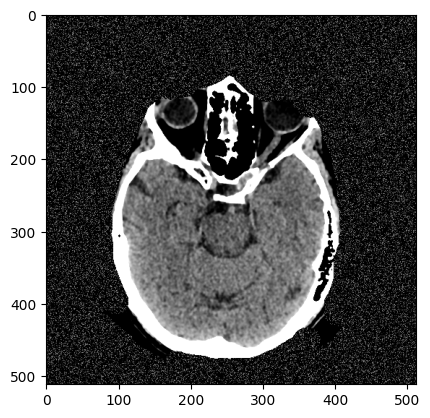

In [ ]:
base_dir = "/content/drive/MyDrive/dataset_jpr_train/1/002360/"
output_base_dir = "/content/drive/MyDrive/png_files"  # Update this path as necessary

root_dir = "1.2.840.12345.10001026308784318024432921250019653260100744677327.dcm"
root_path = os.path.join(base_dir, root_dir)
print(root_path)
output_path = os.path.join(output_base_dir, os.path.splitext(root_dir)[0] + '.png')
os.makedirs(os.path.dirname(output_path), exist_ok=True)
            # Example windowing values, adjust as necessary

dcm = pydicom.read_file(root_path, force=True)
print(dcm)   # Meta data from DICOM file
Intercept = dcm.RescaleIntercept
Slope = dcm.RescaleSlope
image = window_image(dcm, 40, 80, rescale=True)
plt.imshow(image, cmap='gray')

....convert gray image(3 channels) to RGB image....

[[0.     0.     0.3    ... 0.     0.     0.3125]
 [0.     0.     0.3    ... 0.     0.025  0.    ]
 [0.     0.125  0.     ... 0.325  0.     0.    ]
 ...
 [0.3    0.     0.     ... 0.     0.     0.    ]
 [0.     0.25   0.3375 ... 0.     0.     0.3   ]
 [0.1625 0.     0.     ... 0.     0.     0.4125]]
(512, 512, 3)


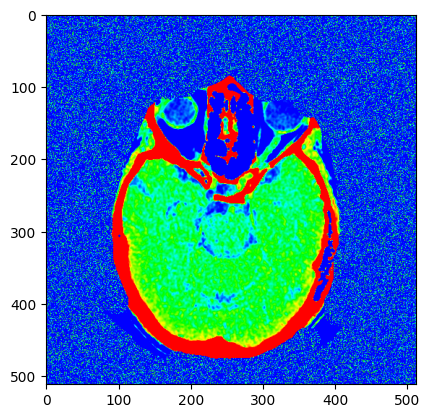

In [ ]:
dcm = pydicom.read_file(root_path, force=True)
image = window_image(dcm, 40, 80)
normalized_image = normalize_image(image)
print(normalized_image)
#img = Image.fromarray((normalized_image * 255).astype(np.uint8))
color_img = GrayImageToColorImage(image)
print(color_img.shape)
plt.imshow(cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB))

# Convert Images in Folders to RGB Images

In [ ]:
based_dir = "/content/drive/MyDrive/dataset_jpr_train/1/"
root_dir = "002360/"
output_dir = "/content/drive/MyDrive/png_files/"

root_path = os.path.join(based_dir, root_dir)
print(root_path)
for dcm_file in os.listdir(root_path):
  dcm_path = os.path.join(root_path, dcm_file)
  output_path = os.path.join(output_dir, root_dir, os.path.splitext(dcm_file)[0]+ ".png")
  dcm = pydicom.read_file(dcm_path, force= True) # There is a need to use force = True due to anonymization reasons.
  if hasattr(dcm, 'pixel_array') is False:    # Check if dcm has pixel array
    continue
  image = window_image(dcm, 40, 80)
  if dcm.PhotometricInterpretation == "MONOCHROME1":
        image = np.invert(image)

  normalized_image = normalize_image(image)
  img = GrayImageToColorImage(normalized_image)
  color_image_array = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  color_image = Image.fromarray((color_image_array * 255).astype(np.uint8))
  os.makedirs(os.path.dirname(output_path), exist_ok=True)
  color_image.save(output_path)
  print(f'PNG file saved at {output_path}')

/content/drive/MyDrive/dataset_jpr_train/1/002360/
PNG file saved at /content/drive/MyDrive/png_files/002360/1.2.840.12345.10193916737469454665435200391700999527745190691366.png
PNG file saved at /content/drive/MyDrive/png_files/002360/1.2.840.12345.10272075865329866300384924806572073050025210190112.png
PNG file saved at /content/drive/MyDrive/png_files/002360/1.2.840.12345.10001026308784318024432921250019653260100744677327.png
PNG file saved at /content/drive/MyDrive/png_files/002360/1.2.840.12345.10148332961301583146652218821393092535351030437223.png
PNG file saved at /content/drive/MyDrive/png_files/002360/1.2.840.12345.10184955795521088491268316565118925637689409651197.png
PNG file saved at /content/drive/MyDrive/png_files/002360/1.2.840.12345.10177536919779694002628663459221223543405001811338.png
PNG file saved at /content/drive/MyDrive/png_files/002360/1.2.840.12345.10098370626634593474590072996031220188955155503130.png
PNG file saved at /content/drive/MyDrive/png_files/002360/1.

# Construct 3D Image of Brain from PNG files

....create 3D array from 2D images....

